In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

import sys
sys.path.append('../')
import plot_util
import util

2022-03-21 02:30:58.722973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-21 02:30:59.462457: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-21 02:30:59.463674: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-21 02:30:59.474685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-21 02:30:59.474707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-21 02:30:59.475951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

# Load data and models

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220301_ELReLMIs54_MUReLMIs31_btag77_VVZ.arrow')
sig['source'] = 'Signal'
sig['is_signal'] = True


bg_others = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                             + '20220301_ELReLMIs54_MUReLMIs31_btag77_others.arrow'))
bg_others['source'] = 'Other'

bg_ttZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                          + '20220301_ELReLMIs54_MUReLMIs31_btag77_ttZ.arrow'))
bg_ttZ['source'] = 'ttZ'

bg_tWZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                          + '20220301_ELReLMIs54_MUReLMIs31_btag77_tWZ.arrow'))
bg_tWZ['source'] = 'tWZ'

bg_tZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                         + '20220301_ELReLMIs54_MUReLMIs31_btag77_tZ.arrow'))
bg_tZ['source'] = 'tZ'

bg_WZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                         + '20220301_ELReLMIs54_MUReLMIs31_btag77_WZ.arrow'))
bg_WZ['source'] = 'WZ'

bg_Zgamma = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                             + '20220301_ELReLMIs54_MUReLMIs31_btag77_Zgamma.arrow'))
bg_Zgamma['source'] = 'Z + gamma'

bg_Zjets = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                            + '20220301_ELReLMIs54_MUReLMIs31_btag77_Zjets.arrow'))
bg_Zjets['source'] = 'Z + jets'

bg_ZZ = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                         + '20220301_ELReLMIs54_MUReLMIs31_btag77_ZZ.arrow'))
bg_ZZ['source'] = 'ZZ'

bg = pd.concat([bg_others, bg_ttZ, bg_tWZ, bg_tZ, bg_WZ, bg_Zgamma, bg_Zjets, bg_ZZ])
bg['is_signal'] = False

In [3]:
train_feats = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                          'v_j_btag77', 'v_j_btag60', 
                                                          'v_j_btag85', 'v_j_btagCont', 'v_j_btag70', 
                                                          'source']])
print('Using the following training features:')
print(sorted(train_feats))

Using the following training features:
['HT', 'MET', 'METPhi', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_ambiguous', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_ambiguous', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zcand_mass', 'Zlep1_ambiguous', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_ambiguous', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'chisq', 'eta_1', 'eta_2', 'eta_3', 'eta_4', 'jet_btagCont_1', 'jet_btagCont_2', 'jet_btagCont_3', 'jet_btagCont_4', 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4', 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4', 'jet_phi_1', 'jet_phi_2', 'jet_phi_3', 'jet_phi_4', 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4', 'lep1_ambiguous', 'lep1_pid', 'lep2_ambiguous', 'lep2_pid', 'lep3_ambiguous', 'lep3_pid', 'lep4_ambiguous', 'lep4_pid', 'leptonic_HT', 'mass_4l', 'other_mass', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'tota

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats], bg[train_feats]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats] = min_max_scaler.transform(df[train_feats])

In [5]:
# Cut to 4l-SF (no Z) signal region
bg = bg[bg.SR == 0.5]
sig = sig[sig.SR == 0.5]

## Set up k-folds

In [6]:
combined_data = pd.concat([sig[train_feats + ['wgt', 'is_signal', 'source']], 
                           bg[train_feats + ['wgt', 'is_signal', 'source']]], 
                          ignore_index=True)
combined_labels = np.concatenate([np.ones(len(sig)), np.zeros(len(bg))])

K_FOLDS = 5
k_folder = StratifiedKFold(n_splits = K_FOLDS, random_state=314, shuffle=True)

# Assign k-folds
combined_data['k_fold'] = -1
for i, (_, test_index) in enumerate(k_folder.split(combined_data, combined_labels)):
    combined_data.loc[test_index, 'k_fold'] = i

## Load models and evaluate on data

In [7]:
nn_out_col = 'nn_out'

combined_data[nn_out_col] = -1

for k in range(K_FOLDS):
    # Load model
    model_dir = '../k_folding_tests/models/SR_SF_noZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    K.clear_session()
    classifier = keras.models.load_model(model_dir + model_name)
    
    # We test classifier k on slice k
    x_test = combined_data[combined_data.k_fold == k][train_feats]
    combined_data.loc[combined_data.k_fold == k, nn_out_col] = classifier.predict(x_test, batch_size=10000)

2022-03-21 02:31:09.972348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 02:31:09.974465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-21 02:31:09.974523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-21 02:31:09.974552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-21 02:31:09.974571: I tensorflow/stream_executor/plat

# Greedy scan from left

Here we will scan from the left. At each step, we will maximize the remaining significance. As a termination condition, we will require that each bin contain at least 10 events.

In [8]:
remaining_events = combined_data.copy()
bin_edges = [0]

min_bin_count = 5
while sum(remaining_events.wgt) > min_bin_count:
    remaining_sig = 0
    new_edge = 1
    for nn_cut in np.linspace(bin_edges[-1], 1, 50)[1:]:
        events_to_right = remaining_events[remaining_events.nn_out > nn_cut]
        
        n_sig = np.sum(events_to_right[events_to_right.is_signal == 1].wgt)
        n_bg = np.sum(events_to_right[events_to_right.is_signal == 0].wgt)
        
        tmp_sig = util.significance(n_sig, n_bg)
        
        current_bin_events = remaining_events[(remaining_events.nn_out > bin_edges[-1])
                                              &(remaining_events.nn_out < nn_cut)]
        current_bin_count = np.sum(current_bin_events.wgt)
        
        if tmp_sig > remaining_sig and (current_bin_count > min_bin_count 
                                        and np.sum(events_to_right.wgt) > min_bin_count):
            remaining_sig = tmp_sig
            new_edge = nn_cut
           
    print('Added edge at', new_edge)
    print('Remaining significance:', remaining_sig)
    print('Remaining events:', sum(remaining_events[remaining_events.nn_out > new_edge].wgt))
    bin_edges.append(new_edge)
    remaining_events = remaining_events[remaining_events.nn_out > new_edge]
# bin_edges.append(1)

Added edge at 0.8775510204081632
Remaining significance: 1.3907627922601467
Remaining events: 12.170539115952305
Added edge at 0.9225322782174094
Remaining significance: 1.311706134826746
Remaining events: 7.140142537356889
Added edge at 1
Remaining significance: 0
Remaining events: 0


In [9]:
bin_significances = [0] * (len(bin_edges) - 1)

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]
    
    bin_events = combined_data[(combined_data.nn_out > bin_start)&(combined_data.nn_out < bin_end)]
    n_sig = np.sum(bin_events[bin_events.is_signal == 1].wgt)
    n_bg = np.sum(bin_events[bin_events.is_signal == 0].wgt)
    
    bin_significances[i] = util.significance(n_sig, n_bg)
    print('Bin', i+1, 'significance:', bin_significances[i], 'sigma')
    
total_sig = np.sqrt(np.sum(np.square(bin_significances)))
print('Total significance:', total_sig, 'sigma')

Bin 1 significance: 0.2624545834683043 sigma
Bin 2 significance: 0.6241621775470627 sigma
Bin 3 significance: 1.3118774054175832 sigma
Total significance: 1.476307271237591 sigma


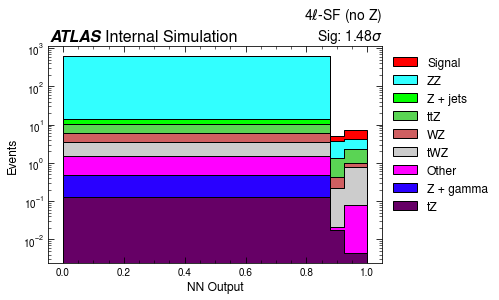

In [10]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]

bg_ZZ_sample = bg_sample[bg_sample.source == 'ZZ']
bg_Zjets_sample = bg_sample[bg_sample.source == 'Z + jets']
bg_ttZ_sample = bg_sample[bg_sample.source == 'ttZ']
bg_WZ_sample = bg_sample[bg_sample.source == 'WZ']
bg_tWZ_sample = bg_sample[bg_sample.source == 'tWZ']
bg_other_sample = bg_sample[bg_sample.source == 'Other']
bg_Zgamma_sample = bg_sample[bg_sample.source == 'Z + gamma']
bg_tZ_sample = bg_sample[bg_sample.source == 'tZ']

color_palette = plot_util.color_scheme
colors = [color_palette['tZ'],
          color_palette['Zgamma'],
          color_palette['others'],
          color_palette['tWZ'],
          color_palette['WZ'],
          color_palette['ttZ'],
          color_palette['Zjets'],
          color_palette['ZZ'],
          color_palette['WVZ']
         ]

plot_util.make_nn_output_source_plot(bg_tZ_sample, 
                                     bg_Zgamma_sample,
                                     bg_other_sample,
                                     bg_tWZ_sample,
                                     bg_WZ_sample,
                                     bg_ttZ_sample,
                                     bg_Zjets_sample,
                                     bg_ZZ_sample,
                                     sig_sample, colors=colors, column='nn_out', bins=bin_edges, log=True, 
                                     save=True, 
                                     save_dir='plots/', save_name='greedy_left_SF_noZ', 
                                     title='4$\ell$-SF (no Z)'+'\nSig: %.2f$\sigma$'%total_sig)

# Greedy scan from right

Here we will scan from the right. At each step, we will maximize the current significance. As a termination condition, we will require that each bin contain a minimum number of events.

In [8]:
remaining_events = combined_data.copy()
bin_edges = [1]

min_bin_count = 5
while sum(remaining_events.wgt) > min_bin_count:
    remaining_sig = 0
    new_edge = 0
    for nn_cut in np.linspace(0, bin_edges[0], 50)[:-1]:
        current_bin_events = remaining_events[(remaining_events.nn_out < bin_edges[0])
                                              &(remaining_events.nn_out > nn_cut)]
        current_bin_count = np.sum(current_bin_events.wgt)
        
        n_sig = np.sum(current_bin_events[current_bin_events.is_signal == 1].wgt)
        n_bg = np.sum(current_bin_events[current_bin_events.is_signal == 0].wgt)
        
        tmp_sig = util.significance(n_sig, n_bg)
        
        if tmp_sig > remaining_sig and current_bin_count > min_bin_count:
            remaining_sig = tmp_sig
            new_edge = nn_cut
           
    print('Added edge at', new_edge)
    print('Remaining significance:', remaining_sig)
    print('Remaining events:', sum(remaining_events[remaining_events.nn_out < new_edge].wgt))
    bin_edges.insert(0, new_edge)
    remaining_events = remaining_events[remaining_events.nn_out < new_edge]
# bin_edges.append(1)

Added edge at 0.8775510204081632
Remaining significance: 1.3908506736596096
Remaining events: 629.3942952636105
Added edge at 0.6268221574344024
Remaining significance: 0.5169649686456671
Remaining events: 598.9816127056281
Added edge at 0.17909204498125783
Remaining significance: 0.2321953391162691
Remaining events: 477.77285372153733
Added edge at 0.05116915570893081
Remaining significance: 0.07060276490690727
Remaining events: 316.01829753210114
Added edge at 0.018796832709403154
Remaining significance: 0.022369987515236365
Remaining events: 174.28911981552167
Added edge at 0.0053705236312580435
Remaining significance: 0.007948315175392014
Remaining events: 49.28485653260464
Added edge at 0.0014248328001296852
Remaining significance: 0.0013744677925822595
Remaining events: 6.50468190449788
Added edge at 0.0005815644082161981
Remaining significance: 9.13171706536559e-05
Remaining events: 1.321681269173534


In [9]:
bin_significances = [0] * (len(bin_edges) - 1)

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]
    
    bin_events = combined_data[(combined_data.nn_out > bin_start)&(combined_data.nn_out < bin_end)]
    n_sig = np.sum(bin_events[bin_events.is_signal == 1].wgt)
    n_bg = np.sum(bin_events[bin_events.is_signal == 0].wgt)
    
    bin_significances[i] = util.significance(n_sig, n_bg)
    print('Bin', i+1, 'significance:', bin_significances[i], 'sigma')
    
total_sig = np.sqrt(np.sum(np.square(bin_significances)))
print('Total significance:', total_sig, 'sigma')

Bin 1 significance: 9.13171706536559e-05 sigma
Bin 2 significance: 0.0013744677925822595 sigma
Bin 3 significance: 0.007948315175392014 sigma
Bin 4 significance: 0.022369987515236365 sigma
Bin 5 significance: 0.07060276490690727 sigma
Bin 6 significance: 0.2321953391162691 sigma
Bin 7 significance: 0.5169649686456671 sigma
Bin 8 significance: 1.3908506736596096 sigma
Total significance: 1.503723142969517 sigma


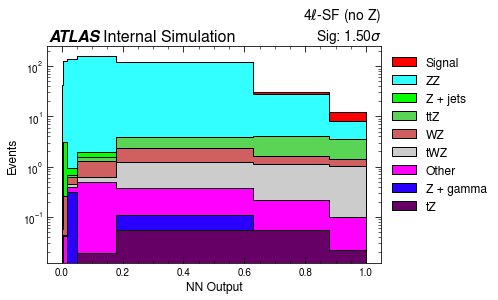

In [10]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]

bg_ZZ_sample = bg_sample[bg_sample.source == 'ZZ']
bg_Zjets_sample = bg_sample[bg_sample.source == 'Z + jets']
bg_ttZ_sample = bg_sample[bg_sample.source == 'ttZ']
bg_WZ_sample = bg_sample[bg_sample.source == 'WZ']
bg_tWZ_sample = bg_sample[bg_sample.source == 'tWZ']
bg_other_sample = bg_sample[bg_sample.source == 'Other']
bg_Zgamma_sample = bg_sample[bg_sample.source == 'Z + gamma']
bg_tZ_sample = bg_sample[bg_sample.source == 'tZ']

color_palette = plot_util.color_scheme
colors = [color_palette['tZ'],
          color_palette['Zgamma'],
          color_palette['others'],
          color_palette['tWZ'],
          color_palette['WZ'],
          color_palette['ttZ'],
          color_palette['Zjets'],
          color_palette['ZZ'],
          color_palette['WVZ']
         ]

plot_util.make_nn_output_source_plot(bg_tZ_sample, 
                                     bg_Zgamma_sample,
                                     bg_other_sample,
                                     bg_tWZ_sample,
                                     bg_WZ_sample,
                                     bg_ttZ_sample,
                                     bg_Zjets_sample,
                                     bg_ZZ_sample,
                                     sig_sample, colors=colors, column='nn_out', bins=bin_edges, log=True, 
                                     save=True, 
                                     save_dir='plots/', save_name='greedy_right_SF_noZ', 
                                     title='4$\ell$-SF (no Z)'+'\nSig: %.2f$\sigma$'%total_sig)